This notebook evaluates a Vector Autoregressive Model.

The data transformations and preparation are used from the Data-Transformations notebook.

## Import Packages

In [1]:
import gresearch_crypto

from datetime import datetime
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import gc
import numpy as np
import pandas as pd

## Declare variables

In [2]:
train_filepath = '/kaggle/input/g-research-crypto-forecasting/train.csv'
asset_details_filepath = '/kaggle/input/g-research-crypto-forecasting/asset_details.csv'

## Declare Cleaning Functions

In [3]:
def clean_dates(df):
    '''
    Function to clean timestamps of an individual coin 
    by the earliest and latest timestamps observed for that coin.
    Also fills in missing values by the method chosen for the interpolate function.
    
    Inputs: 
        df (pd.DataFrame.GroupBy object) :
            Grouped Dataframe by unique coins. All timestamps must be
            in intervals of 60 seconds.

    Outputs:
        constant_dates_df (pd.DataFrame) :
            Dataframe with timestamps and filled missing values.
    '''
    
    df = df.copy()
    
    dates = range(min(df["timestamp"]), max(df["timestamp"]), 60)
    
    df.set_index("timestamp", inplace = True)
    
    df = df.reindex(dates)
    
    # replace the 9 infinite values with NaN, which are interpolated in the next line
    df.replace([np.inf, -np.inf], np.nan, inplace = True)
    
    # don't fill missing values at end of dataset, where they do not
    # have ending observations to interpolate with
    df.interpolate(method = "linear", inplace = True, limit_area = "inside")
    
    return df
    
def standardize_data(df):
    '''
    Function to standardize data by creating rows for every timestamp
    and subsetting to only consider when all coins had their first observation made.
    
    Inputs:
        df (pd.DataFrame) :
            Time series data to be standardized
            
    Outputs:
        standard_df (pd.DataFrame) :
            Time series data now standardized
    '''
    
    # deep copy to not alter the original
    df = df.copy()
    
    # fill missing rows / values between coin's start and stop date
    # Note: Missing rows beyond an individual coin's start / stop date are not created,
    # only those between are filled in
    standard_df = df.groupby("Asset_ID").apply(clean_dates).reset_index(level = 0, drop = True)
    
    # reset twice so timestamp is only a column and not also index, 
    # this makes each entry have a unique index
    standard_df = standard_df.reset_index()
    
    # get the earliest timestamp for each coin, then get the latest timestamp out of those.
    # this shows when the latest coin was introduced, after which there are observations for
    # all coins
    first_timestamp = max(standard_df.groupby("Asset_ID")["timestamp"].min())
    
    # subset to only consider the time period where observations existed for all coins
    standard_df = standard_df.loc[standard_df["timestamp"] >= first_timestamp]
    
    # drop ending rows with missing values
    standard_df.dropna(inplace = True)
    
    # convert to int to better reflect nature of data
    standard_df["Count"] = standard_df["Count"].astype("int")
    standard_df["Asset_ID"] = standard_df["Asset_ID"].astype("int")
    
    return standard_df

def df_long_to_wide(df, group_column, cols_to_keep, time_col):
    '''
    Function to transform data from long to wide format.
    
    Assumes passed DataFrame is in long format, where each row corresponds to
    a unique observation in cross section and in time (i.e. the values of a specific
    coin at a specific time)
    
    Returns a formatted DataFrame in wide format, where each row corresponds only 
    to a unique time. 
    
    Inputs:
        df (pd.DataFrame) :
            Time series data in long format
            
        group_column (str) :
            String of the column to be grouped by, representing
            the cross sectional identifier of the data 
            (e.g. identifier for which coin out of 14 
            cryptocurrencies the row represents)
            
        cols_to_keep (list of strs) :
            List of strings, where each string represents a column
            to keep and include in the new wide dataframe. Each column
            will be repeated for each group (e.g. for two groups and
            three columns, each row will have six appended columns
            in the wide df) 
            
        time_col (str) :
            String of the column that contains time information
            
    Outputs:
        wide_df (pd.DataFrame) :
            Time series data in wide format
    '''
    
    df = df.copy()

    # extract only the unique times and sort them in a new dataframe
    unique_times = df.loc[:, time_col].unique()
    wide_df = pd.DataFrame(data = {time_col : sorted(unique_times)})

    grouped_df = df.groupby(group_column)
    group_list = [grouped_df.get_group(x).copy() for x in grouped_df.groups]

    for group in group_list:
        
        # create new unique names for the cols indicating which cross section
        # they belong to
        new_col_names = [name + "_" + str(group.loc[:, group_column].iloc[0]) 
                         for name in cols_to_keep]

        rename_dict = {col : new_col for col in cols_to_keep for new_col in new_col_names}
        group.rename(columns = rename_dict, inplace = True, errors = "raise")

        # add columns to the wide df
        wide_df = wide_df.merge(group.loc[:, new_col_names + [time_col]], on = time_col,
                               how = "left")

        gc.collect()

    return wide_df

def weight_df(df, factor, col_factor = None):
    '''
    Weights each entry in df by factor, and each column additionally
    by col_factor.
    
    Inputs:
    
        df (pd.DataFrame) :
            Dataframe whose columns will be weighted, i.e. multiplied by
            factor

        factor (int or float) :
            Factor to multiply all observations in the dependent variable by,
            used for increasing its magnitude from between 0 and 1 to a larger
            range

        col_factor (None or pd.DataFrame) :
            If not none, dataframe containing the weights to multiply each
            dependent variable by separately. Weights are assumed to already
            be aligned with their respective dependent variables.
        
    Outputs:
    
        df (pd.DataFrame) :
            Dataframe with weighted columns
    '''
    
    df = df.copy()
    
    df = df * factor
    
    if col_factor is not None:
        
        col_factor.index = df.columns
        df = df * col_factor
        
    return df

def unweight_df(df, factor, col_factor):
    '''
    Unweights each entry in df by factor, and each column additionally
    by col_factor.
    
    Inputs:
    
        df (pd.DataFrame) :
            Dataframe whose columns will be weighted, i.e. multiplied by
            factor

        factor (int or float) :
            Factor to multiply all observations in the dependent variable by,
            used for increasing its magnitude from between 0 and 1 to a larger
            range

        col_factor (None or pd.DataFrame) :
            If not none, dataframe containing the weights to multiply each
            dependent variable by separately. Weights are assumed to already
            be aligned with their respective dependent variables.
        
    Outputs:
    
        df (pd.DataFrame) :
            Dataframe with weighted columns
    '''
    
    df = df.copy()
    
    df = df / factor
    
    if col_factor is not None:
        
        col_factor.index = df.columns
        df = df / col_factor
        
    return df

## Import and Clean Data

In [4]:
df = pd.read_csv(train_filepath)
asset_details_df = pd.read_csv(asset_details_filepath)

standard_df = standardize_data(df)
standard_df = df_long_to_wide(standard_df, "Asset_ID", ["Target"], "timestamp")

latest_timestamp = standard_df.loc[:, "timestamp"].max()

# 60 seconds per minute, 60 minutes per hour, 24 hours per day, ~30 days per month,
# for 3 months
cutoff_timestamp = 60*60*24*30*3

standard_train_df = standard_df.loc[(latest_timestamp - standard_df["timestamp"]) > cutoff_timestamp]
standard_test_df = standard_df.loc[(latest_timestamp - standard_df["timestamp"]) <= cutoff_timestamp]

standard_train_df.set_index("timestamp", inplace = True)
standard_test_df.set_index("timestamp", inplace = True)

# apply weighting factors
factor = 100000
standard_train_df = weight_df(standard_train_df, factor, asset_details_df.loc[:, "Weight"])
#standard_test_df = weight_df(standard_test_df, factor, None)

In [5]:
del df
gc.collect()

88

In [6]:
standard_train_df

,Target_0,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7,Target_8,Target_9,Target_10,Target_11,Target_12,Target_13
timestamp,,,,,,,,,,,,,,
1555079640,-428.601057,-810.201466,-2501.848122,-409.082168,1273.892116,-1351.769298,-344.865200,-133.479625,4951.068514,515.746351,-8685.815791,1308.660597,-167.407190,-909.822434
1555079700,-384.191978,-314.461236,-1111.167218,-405.289036,1575.334501,-722.031773,-426.168559,169.126450,0.000000,682.408290,-8684.850057,1712.128427,-134.707550,-1494.696275
1555079760,-120.837971,-577.312485,-1940.091489,-530.378145,1799.733033,-1537.131445,-466.576869,-1133.167384,4824.417631,313.247956,-8683.884322,1617.828911,-262.031877,9.151991
1555079820,135.679988,-648.932827,-150.595049,-323.434547,1949.007934,-4153.521420,-290.442977,-60.026256,370.433733,199.633773,-8682.918588,1900.105166,-342.245117,-346.594599
1555079880,0.000000,-713.048849,-3675.017624,-391.446844,1948.305589,-1807.238018,-407.021686,-2.217920,4967.369696,56.731864,-8681.952853,1921.260677,-326.068917,-1488.158902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624405140,919.967760,-855.230899,775.878092,1521.499359,-305.986149,-2235.294059,10.656061,60.851706,1669.665201,-314.772867,1265.863249,-1527.082516,173.107518,-12.778084
1624405200,1203.439803,-958.262606,2451.394070,1415.260739,-572.724992,-1729.815620,136.072524,-69.938044,1719.338834,254.907732,2213.464328,-1425.846124,251.833089,-263.279868
1624405260,1416.894452,-773.932996,956.448488,1056.997446,-338.752918,-1002.607459,344.388926,-226.868057,2517.725355,241.608414,2263.712981,-1419.957624,350.088975,190.789376


In [7]:
standard_test_df

,Target_0,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7,Target_8,Target_9,Target_10,Target_11,Target_12,Target_13
timestamp,,,,,,,,,,,,,,
1624405440,0.007666,-0.001197,0.005524,0.005235,-0.004115,-0.002951,0.002168,-0.002057,0.010136,0.000865,0.004384,-0.009090,0.001459,0.002707
1624405500,0.013220,-0.001430,0.007835,0.002967,-0.003292,-0.003119,0.001220,0.004599,0.008768,-0.002387,0.011461,-0.007924,0.002208,0.001617
1624405560,0.003928,-0.001494,0.005463,0.003012,0.000253,-0.001243,-0.001406,0.001828,-0.001801,-0.002253,0.003572,-0.006417,0.003931,0.001282
1624405620,0.002770,-0.001203,0.003554,0.002526,-0.001437,0.000759,-0.000607,-0.000611,-0.006199,0.001865,0.000289,-0.005295,0.000273,0.001187
1624405680,-0.003693,-0.000965,0.003438,0.000898,-0.000081,0.001166,0.001265,-0.003541,-0.009373,0.002602,-0.005821,-0.006012,-0.000477,0.001080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1632181200,0.002325,0.002084,0.002919,-0.003660,-0.001142,0.000941,-0.001309,0.000468,0.000664,0.002442,0.001008,-0.001876,-0.000743,0.000199
1632181260,0.000995,0.003246,-0.001943,-0.000785,-0.001968,0.000416,-0.000736,-0.000676,-0.002656,0.000665,-0.001030,-0.004123,-0.000860,-0.003477
1632181320,0.001499,0.003108,-0.000911,-0.001108,-0.000885,-0.000383,-0.000491,-0.001177,-0.003244,-0.000453,0.000006,-0.003768,-0.001822,-0.002437


In [8]:
asset_details_df

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


## Define and Train Model

In [9]:
model = VAR(standard_train_df)

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [10]:
model_lag_order_results = model.select_order(15)

In [11]:
model_lag_order_results.summary()

,AIC,BIC,FPE,HQIC
0,197.6,197.6,6.282e+85,197.6
1,175.4,175.4,1.522e+76,175.4
2,175.0,175.0,1.007e+76,175.0
3,175.0,175.0,9.592e+75,175.0
4,174.9,174.9,9.442e+75,174.9
5,174.9,174.9,9.305e+75,174.9
6,174.9,174.9,9.176e+75,174.9
7,174.9,174.9,8.974e+75,174.9
8,174.9,174.9,8.792e+75,174.9
9,174.8,174.9,8.556e+75,174.8


In [12]:
selected_lags = model_lag_order_results.selected_orders["aic"]
fit_results = model.fit(maxlags = selected_lags, trend = "n")

fit_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 01, Jan, 2022
Time:                     23:58:30
--------------------------------------------------------------------
No. of Equations:         14.0000    BIC:                    174.030
Nobs:                 1.15542e+06    HQIC:                   174.008
Log likelihood:      -1.23471e+08    FPE:                3.69135e+75
AIC:                      174.000    Det(Omega_mle):     3.68197e+75
--------------------------------------------------------------------
Results for equation Target_0
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
L1.Target_0           0.790259         0.000952          829.927           0.000
L1.Target_1           0.024764         0.001089           22.739           0.000
L1.Target_2           0.000111         0.000366          

In [13]:
forecasts = fit_results.forecast(y = standard_train_df.iloc[-selected_lags:].values, 
                                 steps = len(standard_test_df))

forecast_df = pd.DataFrame(data = forecasts, columns = standard_test_df.columns)
forecast_df = unweight_df(forecast_df, factor, asset_details_df.loc[:, "Weight"])

In [14]:
forecast_df

,Target_0,Target_1,Target_2,Target_3,Target_4,Target_5,Target_6,Target_7,Target_8,Target_9,Target_10,Target_11,Target_12,Target_13
0,0.014084,-0.002923,0.002937,0.005494,-0.007101,0.000552,0.001276,0.001230,0.022872,0.002102,0.012859,-0.006978,0.004034,0.002246
1,0.014092,-0.003156,0.002780,0.005018,-0.006776,0.000743,0.001237,0.000555,0.021496,0.001997,0.013498,-0.005974,0.003800,0.002216
2,0.013291,-0.003231,0.002292,0.004646,-0.006323,0.001867,0.000855,0.001283,0.017544,0.001434,0.013545,-0.003955,0.003766,0.002253
3,0.012738,-0.003144,0.001563,0.003907,-0.005776,0.002364,0.000337,0.001353,0.015734,0.001256,0.013503,-0.002358,0.003471,0.002355
4,0.011356,-0.003069,0.001062,0.003191,-0.005211,0.002855,0.000057,0.001371,0.014446,0.001237,0.012919,-0.001050,0.003337,0.002666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129596,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
129597,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
129598,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
129599,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000


## Define Evaluation Functions

In [15]:
def rmse(preds, true):
    '''
    Calculates Root Mean Squared Error (RMSE) between
    continuous predictions and true values.
    
    Inputs:
        preds (pd.DataFrame) :
            Predictions of the continous variable(s)
        
        true (pd.DataFrame) :
            True values of the continuous variable(s)
            
    Outputs:
        rmse (float) :
            RMSE as a float
    '''
    # align indices
    preds = preds.copy()
    true = true.copy()
    preds.index = true.index
    
    # get squared error for each coin
    se = (np.square(true.subtract(preds))).sum()

    # get mean squared error for each coin
    mse = se / len(true)

    # get root mean squared error for each coin
    rmse = (mse)**0.5
    
    return rmse
    
def binary_accuracy(preds, true):
    '''
    Calculates binary accuracy between
    continuous predictions and true values. Binary accuracy
    is 1 when the forecasted Target is of the same sign
    as the true Target, and zero otherwise.
    
    Inputs:
        preds (pd.DataFrame) :
            Predictions of the continous variable(s)
        
        true (pd.DataFrame) :
            True values of the continuous variable(s)
            
    Outputs:
        bin_pos_acc (pd.Series) :
            Binary accuracy for only positively valued
            predictions as a float
            
        bin_neg_acc (pd.Series) :
            Binary accuracy for only negatively valued
            predictions as a float
    
        bin_acc (pd.Series) :
            Binary accuracy as a float
    '''
    
    # align indices
    preds = preds.copy()
    true = true.copy()
    preds.index = true.index
    
    # find which predictions SHOULD have been
    # greater or less than zero
    true_pos = preds[true > 0]
    true_neg = preds[true < 0]
    
    num_pos_correct = true_pos[true_pos > 0].count()
    num_neg_correct = true_neg[true_neg < 0].count()
    num_correct = num_pos_correct + num_neg_correct
    
    num_total_pos = true_pos.count()
    num_total_neg = true_neg.count()
    num_total = true.count()
    
    bin_pos_acc = num_pos_correct / num_total_pos
    bin_neg_acc = num_neg_correct / num_total_neg
    bin_acc = num_correct / num_total
    
    return bin_pos_acc, bin_neg_acc, bin_acc

def corr(preds, true):
    '''
    Calculates Pearson correlation coefficient between 
    continuous predictions and true values.
    
    Inputs:
        preds (pd.DataFrame) :
            Predictions of the continous variable(s)
        
        true (pd.DataFrame) :
            True values of the continuous variable(s)
            
    Outputs:
        corr (pd.Series) :
            Pearson correlation coefficient for
            each group
    '''
    
    preds = preds.copy()
    true = true.copy()
    preds.index = true.index
    
    corr = preds.corrwith(true)
    
    return corr

def weighted_corr(preds, true, weights):
    '''
    Calculates weighted Pearson correlation coefficient 
    between continuous predictions and true values. Assumes
    each group to be weighted is separated by column in preds
    and true.
    
    Inputs:
        preds (pd.DataFrame) :
            Predictions of the continous variable(s)
        
        true (pd.DataFrame) :
            True values of the continuous variable(s)
            
        weights (pd.Series) :
            Weights 
            
    Outputs:
        weighted_corr (float) :
            Weighted Pearson correlation coefficient
            for entire set of observations
    '''
    
    preds = preds.copy()
    true = true.copy()
    weights = weights.copy()
    preds.index = true.index
    weights.index = preds.columns
    
    weighted_preds = preds * weights
    weighted_true = true * weights
    weight_sum = np.sum(weights * len(preds))

    weighted_preds_mean = np.sum(np.sum(weighted_preds)) / weight_sum
    weighted_true_mean = np.sum(np.sum(weighted_true)) / weight_sum

    weighted_preds_cov = np.sum(np.sum(weights * 
                          (preds - weighted_preds_mean) * 
                          (preds - weighted_preds_mean))) / weight_sum
    weighted_true_cov = np.sum(np.sum(weights * 
                          (true - weighted_true_mean) * 
                          (true - weighted_true_mean))) / weight_sum
    weighted_cov = np.sum(np.sum(weights * 
                          (preds - weighted_preds_mean) * 
                          (true - weighted_true_mean))) / weight_sum
    
    weighted_corr_ = weighted_cov / np.sqrt(weighted_preds_cov * weighted_true_cov)
    
    return weighted_corr_

## Make Evaluations

In [16]:
results_df = rmse(forecast_df, standard_test_df).to_frame(name = "rmse")
    
bin_pos_acc, bin_neg_acc, bin_acc = binary_accuracy(forecast_df, standard_test_df)
results_df["bin_acc_pos"] = 100*bin_pos_acc
results_df["bin_acc_neg"] = 100*bin_neg_acc
results_df["bin_acc_total"] = 100*bin_acc

corr_ = corr(forecast_df, standard_test_df)
results_df["corr"] = corr_
print(results_df)

print("\nTotal RMSE: " + str(results_df["rmse"].sum()))
print("Binary accuracy (%):")
print("\tPositive")
print("\tAverage: " + str(round((100*bin_pos_acc).mean(), 2)) + 
      ", Weighted Average: " + 
      str(round(np.average(100*bin_pos_acc.values, 
                     weights = asset_details_df.loc[:, "Weight"].values), 2)))
print("\tNegative")
print("\tAverage: " + str(round((100*bin_neg_acc).mean(), 2)) + 
      ", Weighted Average: " + 
      str(round(np.average(100*bin_neg_acc.values, 
                           weights = asset_details_df.loc[:, "Weight"].values), 2)))
print("\tTotal")
print("\tAverage: " + str(round((100*bin_acc).mean(), 2)) + 
      ", Weighted Average: " + 
      str(round(np.average(100*bin_acc.values, 
                           weights = asset_details_df.loc[:, "Weight"].values), 2)))
print("Simple weighted correlation: " + 
      str(round(np.average(corr_.values, 
                           weights = asset_details_df.loc[:, "Weight"].values), 4)))
weighted_corr_ = weighted_corr(forecast_df, standard_test_df, asset_details_df.loc[:, "Weight"])
print("Complex weighted correlation: " + str(round(weighted_corr_, 4)))

gc.collect()

               rmse  bin_acc_pos  bin_acc_neg  bin_acc_total      corr
Target_0   0.002570    69.274788     0.058047      34.309920 -0.015861
Target_1   0.001538    68.490288     0.093331      33.431841  0.016103
Target_2   0.002154     0.103113    68.557594      35.773644  0.021040
Target_3   0.003056    69.298428     0.056561      33.404063  0.000847
Target_4   0.003683    68.429171     0.100998      31.888643 -0.005514
Target_5   0.002955    68.023425     0.131628      32.603143  0.003549
Target_6   0.001784    68.466580     0.033500      33.789863  0.007525
Target_7   0.003326    68.523225     0.056843      32.277529 -0.000190
Target_8   0.011491    69.493677     0.039695      34.237390  0.000853
Target_9   0.003107     0.107511    68.486371      35.606207 -0.000713
Target_10  0.005012    70.294482     0.000000      34.995100  0.043895
Target_11  0.003974    68.670817     0.061257      34.074583  0.010611
Target_12  0.003035    68.123268     0.041248      32.463484 -0.007775
Target

35670

In [17]:
print( "Percentage of non-significant coefficients: " +
    str(round(100*sum(sum(fit_results.pvalues.values > 0.05)) / fit_results.pvalues.values.size)) +
     "%")

Percentage of non-significant coefficients: 39%


Shown above, most coefficients are significant in the VAR model. This is impressive, as there are 14 * 14 = 196 coefficients in total. This comes from 14 equations with 14 coefficients for each variable.

## Visualize Model

The fitted values can be overlaid with the original data

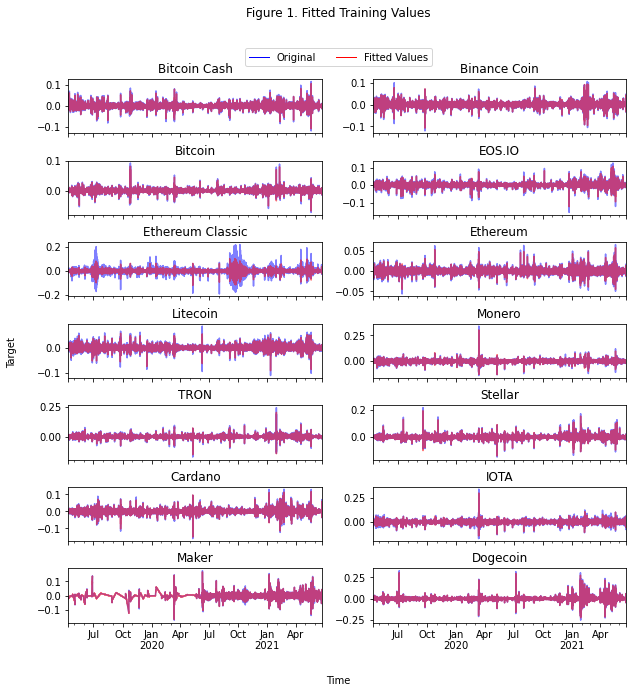

In [22]:
temp_df = standard_df.loc[(latest_timestamp - standard_df["timestamp"]) > cutoff_timestamp].copy()
temp_df.loc[:, "datetime"] = pd.to_datetime(temp_df.loc[:, "timestamp"].values, 
                                                unit = "s", infer_datetime_format = True)
temp_fit = fit_results.fittedvalues.copy()
temp_fit = unweight_df(temp_fit, factor, asset_details_df.loc[:, "Weight"])
temp_fit["timestamp"] = temp_fit.index
temp_fit.loc[:, "datetime"] = pd.to_datetime(temp_fit.loc[:, "timestamp"].values, 
                                                unit = "s", infer_datetime_format = True)

fig, axes = plt.subplots(nrows = int(len(asset_details_df)/2), ncols = 2, 
                         sharex = True, figsize = (10,10))
axes = axes.flatten()

color_one = "blue"
color_two = "red"
alpha = 0.5

for ax, asset in zip(axes, asset_details_df["Asset_ID"]):
    col_string = "Target_" + str(asset)
    temp_df.plot(x = "datetime",
        y = col_string, ax = ax, legend = False, xlabel = "", ylabel = "", 
        color = color_one, alpha = alpha,
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    temp_fit.plot(x = "datetime",
        y = col_string, ax = ax, legend = False, xlabel = "", ylabel = "", 
        color = color_two, alpha = alpha,
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    
fig.suptitle("Figure 1. Fitted Training Values")
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Target', va='center', rotation='vertical')
fig.subplots_adjust(hspace=.5)

# create custom legend
handles = [Line2D([0], [0], color = color_one, lw = 1, label = 'Original'),
           Line2D([0], [0], color = color_two, lw = 1, label = 'Fitted Values')]

fig.legend(handles = handles, loc = "center", bbox_to_anchor=(0.5, 0.91), ncol = 2)

plt.savefig("train.png")    
plt.show()

In [19]:
del temp_df
del temp_fit
gc.collect()

88

The forecasts can also be visualized.

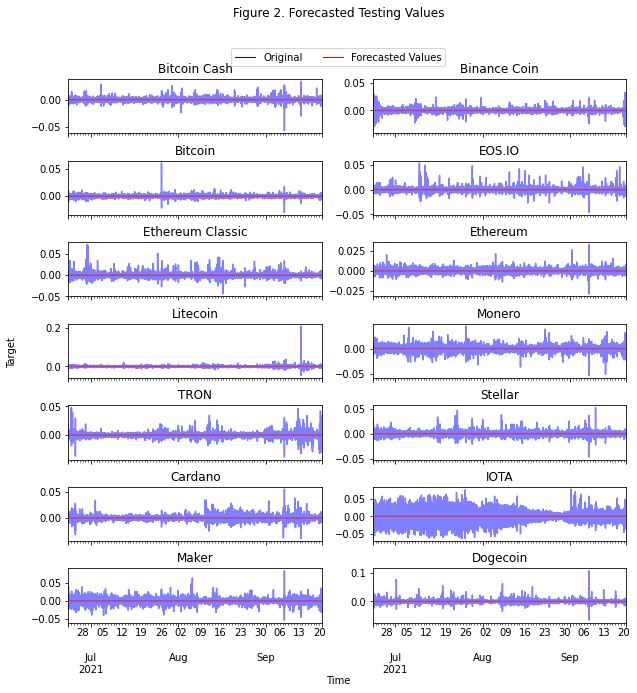

In [20]:
temp_df = standard_df.loc[(latest_timestamp - standard_df["timestamp"]) <= cutoff_timestamp].copy()
temp_df.loc[:, "datetime"] = pd.to_datetime(temp_df.loc[:, "timestamp"].values, 
                                                unit = "s", infer_datetime_format = True)

temp_fit = forecast_df.copy()
temp_fit.loc[:, "datetime"] = temp_df.loc[:, "datetime"].values.copy()

fig, axes = plt.subplots(nrows = int(len(asset_details_df)/2), ncols = 2, 
                         sharex = True, figsize = (10,10))
axes = axes.flatten()

color_one = "blue"
color_two = "red"
alpha = 0.5

for ax, asset in zip(axes, asset_details_df["Asset_ID"]):
    col_string = "Target_" + str(asset)
    temp_df.plot(x = "datetime",
        y = col_string, ax = ax, legend = False, xlabel = "", ylabel = "", 
        color = color_one, alpha = alpha,
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    temp_fit.plot(x = "datetime",
        y = col_string, ax = ax, legend = False, xlabel = "", ylabel = "", 
        color = color_two, alpha = alpha,
        title = asset_details_df.loc[asset_details_df["Asset_ID"] == asset, "Asset_Name"].iloc[0])
    
fig.suptitle("Figure 2. Forecasted Testing Values")
fig.text(0.5, 0.04, 'Time', ha='center')
fig.text(0.04, 0.5, 'Target', va='center', rotation='vertical')
fig.subplots_adjust(hspace=.5)

# create custom legend
handles = [Line2D([0], [0], color = color_one, lw = 1, label = 'Original'),
           Line2D([0], [0], color = color_two, lw = 1, label = 'Forecasted Values')]

fig.legend(handles = handles, loc = "center", bbox_to_anchor=(0.5, 0.91), ncol = 2)

plt.savefig("test.png")    
plt.show()

In [21]:
del temp_df
del temp_fit
gc.collect()

58654